In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

In [55]:
class Cellular_plots_model:

    def __init__(self, n_steps, n_types, n_cells, nx=40, T=1, k=0.5, lamda=1, equilibrium_area=5):

        self.n_steps = n_steps
        self.n_types = n_types
        self.n_cells = n_cells

        self.nx = nx
        self.T = T
        self.k = k
        self.lamda = lamda
        self.equilibrium_area = equilibrium_area
        
        self.initialize_grid_fixed()
        self.initialize_cell_sizes()

        self.step = 0

        if n_types != 3:
            raise Exception("Error: Current J function only accepts 3 types: the M type and two others")

        # M=0, d=1, l=2 
        # Each row has index 0: type_min, index 1: type_max, index 2: J value
        # J values obtained from Glazer 2013. The report did not specify the
        # J value for M, M 
        self.J_table = {
            (0,0): 0, 
            (1,1): 2,
            (1,2): 11,
            (2,2): 14,
            (0,1): 16,
            (0,2): 16,
        }

        for key, value in list(self.J_table.items()):
            self.J_table[(key[1], key[0])] = value

        self.initialize_rands()
        # self.Moore = ((-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1))

    def initialize_grid_random(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2, 2), dtype=int)


        for cell_ID in range(1, self.n_cells + 1):

            # Pick a random latice site which is not yet occupied
            while True:

                # Pick random lattice site
                i, j = np.random.randint(1, self.nx, 2)

                if self.grid[i, j, 0] == 0:
                    break
                
            cell_type = np.random.choice(np.arange(1, self.n_types))

            self.grid[i, j, 0] = cell_ID
            self.grid[i, j, 1] = cell_type
    
    def initialize_grid_fixed(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2, 2), dtype=int)
        
        cells_per_row = int(np.sqrt(self.n_cells))
        cell_width = cell_height = int(np.sqrt(self.equilibrium_area))

        initial_index_i = int((self.nx - np.sqrt(self.n_cells * self.equilibrium_area)) * 0.5)
        initial_index_j = initial_index_i

        for cell_ID in range(1, self.n_cells + 1):
            
            cell_type = np.random.choice(np.arange(1, self.n_types))
  
            # Translate cell ID to a column and row value
            cell_row = (cell_ID - 1) % cells_per_row
            cell_column = (cell_ID - 1) // cells_per_row

            i = initial_index_i + cell_column * cell_width
            j = initial_index_j + cell_row * cell_height
            
            self.grid[i : i + cell_width, j : j + cell_height, 0] = cell_ID
            self.grid[i : i + cell_width, j : j + cell_height, 1] = cell_type

    def initialize_cell_sizes(self):
        
        # key: cell_ID, value: cell_size
        self.cell_sizes = {}#{0: self.nx * self.nx}
        for cell_ID in np.unique(self.grid[:,:,0]):

            count = np.count_nonzero(self.grid[:,:,0] == cell_ID)

            self.cell_sizes[cell_ID] = count
#             self.cell_sizes[0] -= count
            
        print(self.cell_sizes)

    def run(self):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % 10000 == 0:
                print(f"Step: {self.step}", end="\r")
    
    def initialize_rands(self, n=10000):
        self.randints = list(np.random.uniform(size=n))

    def get_rand(self):
        if not self.randints:
            self.initialize_rands()
        return self.randints.pop()

    def update(self):
        # Pick random lattice site
        i, j = int((self.nx-1)*self.get_rand()+1), int((self.nx-1)*self.get_rand()+1) # np.random.randint(1, self.nx, 2)
        cell_ID = self.grid[i, j, 0]
        cell_type = self.grid[i, j, 1]

        # Pick a random neighbour
        von_neumann_neighbourhood = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j-1)]
        von_neumann_index = int(len(von_neumann_neighbourhood)*self.get_rand()) # np.random.randint(0, len(von_neumann_neighbourhood))
        neighbour_i, neighbour_j = von_neumann_neighbourhood[von_neumann_index]

        neighbour_ID = self.grid[neighbour_i, neighbour_j, 0]
        neighbour_type = self.grid[neighbour_i, neighbour_j, 1]

        if cell_ID == neighbour_ID:
            self.step += 1
            return
        
        # Compute hamiltonian vol before updating the lattice site
        old_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        # Update cell sizes
        self.cell_sizes[neighbour_ID] += 1
        self.cell_sizes[cell_ID] -= 1

        # Calculate the new hamiltonian vol with updated cell sizes
        new_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        delta_ham_bond = self.calc_delta_hamiltonian_bond(self.grid, i, j, cell_ID, cell_type, neighbour_ID, neighbour_type)

        delta_hamiltonian = (new_ham_vol - old_ham_vol) + delta_ham_bond
        
        if delta_hamiltonian < 0 or self.get_rand() < np.exp(-delta_hamiltonian/(self.k * self.T)):
            
            # Update grid
            self.grid[i, j, 0] = neighbour_ID
            self.grid[i, j, 1] = neighbour_type

        else:
            # Reset cell size changes
            self.cell_sizes[neighbour_ID] -= 1
            self.cell_sizes[cell_ID] += 1

        self.step += 1
      
    def calc_hamiltonian_vol(self, cell_IDs):

        sigma = 0
        for cell_ID in cell_IDs:

            if cell_ID == 0:
                continue

            cell_area = self.cell_sizes[cell_ID]
            sigma += (cell_area - self.equilibrium_area) ** 2

        return self.lamda * sigma

    def calc_delta_hamiltonian_bond(self, grid, i, j, cell_ID1, cell_type1, cell_ID2, cell_type2):

        old_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID1, cell_type1)
        new_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID2, cell_type2)

        # Twice since the lattice site in the Moore neighbourhood are also affected
        return 2 * (new_ham - old_ham)

    def calc_hamiltonian_bond_new_implemetation(self, grid, i, j, cell_ID, cell_type):
        
        H_bond = 0
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset
                
                cell_prime_ID = grid[i_prime, j_prime, 0]
                cell_prime_type = grid[i_prime, j_prime, 1]
                
                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond
        
    def J(self, type1, type2):

        # Reduces the number of conditions checked
        # type_min = 
        # type_max = 
        
        # try:
        return self.J_table[(type1, type2)]
        # except:
        #     raise Exception(f"Error: No valid J function found. type1: {type1}, type2:{type2}")  

        # for row in self.J_table:

        #     if type_min == row[0] and type_max == row[1]:
        #         return row[2]
          
    def kronecker_delta(self, value1, value2):

        if value1 == value2:
            return 1

        return 0

    def show_grid_every_x_steps(self, x):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % x == 0:
                self.show_grid(clear_plot=True)
           
    def show_grid(self, clear_plot=False):
        
        if clear_plot:
            clear_output(wait=True)
        
        grid = np.array(self.grid, dtype=float)

        # For plotting purposes set M cells to None
        grid[grid==0] = np.nan
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        fig.suptitle(f"Step: {self.step}")

        ax1.matshow(grid[1:-1, 1:-1, 0], cmap='hsv')
        ax1.set_title("Cell IDs")

        ax2.matshow(grid[1:-1, 1:-1, 1], cmap="magma")
        ax2.set_title("Cell types")
        
        plt.tight_layout()
        plt.show()

{0: 6804, 1: 36, 2: 36, 3: 36, 4: 36, 5: 36, 6: 36, 7: 36, 8: 36, 9: 36, 10: 36, 11: 36, 12: 36, 13: 36, 14: 36, 15: 36, 16: 36, 17: 36, 18: 36, 19: 36, 20: 36, 21: 36, 22: 36, 23: 36, 24: 36, 25: 36, 26: 36, 27: 36, 28: 36, 29: 36, 30: 36, 31: 36, 32: 36, 33: 36, 34: 36, 35: 36, 36: 36, 37: 36, 38: 36, 39: 36, 40: 36, 41: 36, 42: 36, 43: 36, 44: 36, 45: 36, 46: 36, 47: 36, 48: 36, 49: 36, 50: 36, 51: 36, 52: 36, 53: 36, 54: 36, 55: 36, 56: 36, 57: 36, 58: 36, 59: 36, 60: 36, 61: 36, 62: 36, 63: 36, 64: 36, 65: 36, 66: 36, 67: 36, 68: 36, 69: 36, 70: 36, 71: 36, 72: 36, 73: 36, 74: 36, 75: 36, 76: 36, 77: 36, 78: 36, 79: 36, 80: 36, 81: 36, 82: 36, 83: 36, 84: 36, 85: 36, 86: 36, 87: 36, 88: 36, 89: 36, 90: 36, 91: 36, 92: 36, 93: 36, 94: 36, 95: 36, 96: 36, 97: 36, 98: 36, 99: 36, 100: 36}


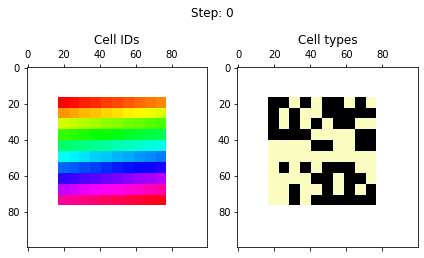

KeyboardInterrupt: 

In [58]:
model = Cellular_plots_model(n_steps=2000000000, n_types=3, n_cells=100, nx=100, equilibrium_area=40, T=20, lamda=1, k=1)
model.show_grid()
model.show_grid_every_x_steps(100000)